# Importando as bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pymannkendall import original_test
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from db import connection_db as conndb
from db import filters
from utils.extracao_interacao import ExtracaoInteracao
from sklearn.metrics import davies_bouldin_score

# Conectando ao banco de dados do MongoDB

Função para conectar ao MongoDB

In [ ]:
def conectar_mongodb(uri, db_name, collection_name):
    mongo_connection = conndb.MongoDBConnection(uri=uri, database_name=db_name, collection_name=collection_name)
    mongo_connection.connect()
    return mongo_connection.collection

In [ ]:
# Definindo os parâmetros de conexão
uri = 'mongodb://localhost:27017/'
db_name = 'dadosVivamente'
collection_name = 'dadosSemFiltros'
collection_name_filtered = 'posts7anos1anos'

collection = conectar_mongodb(uri, db_name, collection_name)
collection_filtrada = conectar_mongodb(uri, db_name, collection_name_filtered)

# Aplicando pipeline para preparação dos dados

Função para aplicar os pipelines de filtro

In [ ]:
def aplicar_pipelines(collection, collection_filtrada):
    collection_filters = filters.CollectionFilters(collection)
    collection_filters_likes = filters.CollectionFilters(collection_filtrada)

    # Aplicar pipelines
    collection_filters.apply_pipeline1('dadosComFiltrosIniciais')
    collection_filters.apply_pipeline2(7, 1, 'posts7anos1anos')
    collection_filters.apply_pipeline3('postsComBDIAndInfos')
    collection_filters.apply_pipeline4('posts')
    collection_filters_likes.apply_pipeline6('likes')

    return collection_filters.collection, collection_filters_likes.collection

In [ ]:
# Aplicando os pipelinesc
collection, collection_filtrada = aplicar_pipelines(collection, collection_filtrada)

# Carregando os dados em um dataframe

In [ ]:
documentos = collection.find()
df_post_original = pd.DataFrame(list(documentos))

# Visualizar as primeiras linhas do dataframe
df_post_original.head()

In [ ]:
documentos_likes = collection_filtrada.find()
df_original_likes = pd.DataFrame(list(documentos_likes))

# Visualizar as primeiras linhas do dataframe
df_original_likes.head()

In [ ]:
# Transformando a coluna sexo em binária
df_post_original['sexo'] = df_post_original['sexo'].map({'F': 0, 'M': 1})

# Removendo colunas desnecessárias
df_post_original.drop(columns=['_id', 'diaDaSemana'], inplace=True)

# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'suicida', 'choro',
    'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]


# Função para preencher valores nulos e converter o tipo de dado
def preencher_e_converter(df, colunas, valor_preenchimento=0, tipo_dados='int64'):
    df[colunas] = df[colunas].fillna(valor_preenchimento)
    df[colunas] = df[colunas].astype(tipo_dados)
    return df

In [ ]:
df_post_original = preencher_e_converter(df_post_original, colunas_para_converter)

In [ ]:
# Remover usuarios que tem menos de 100 posts
df_post_original = df_post_original.groupby('id_usuario').filter(lambda value: len(value) >= 100)

In [ ]:
# Função para manipular datas e filtrar posts
def manipular_e_filtrar_posts(df):
    df['data'] = df['postCreatedTime'].dt.date
    df['data'] = pd.to_datetime(df['data'])
    df['mes'] = df['data'].dt.to_period('M')
    df['semana'] = df['data'].dt.to_period('W')

    df_data = df[df['data'].dt.year == 2017]
    df_data = df_data[~((df_data['data'].dt.month == 12) & (df_data['data'].dt.year == 2017))]
    df_data = df_data[df_data['data'].dt.month >= 5]
    df_data = df_data[df_data['suicida'] == 3]

    # Remover posts vazios
    df_data = df_data.dropna(subset=['postMessage', 'postStory'], how='all')
    df_data = df_data[~((df_data['postMessage'].str.strip() == '') & (df_data['postStory'].str.strip() == ''))]

    return df_data

In [ ]:
df_posts = manipular_e_filtrar_posts(df_post_original)

# Remover usuarios que tem menos de 100 posts
df_posts = df_posts.groupby('id_usuario').filter(lambda value: len(value) >= 100)

df_posts.head()

In [ ]:
# Função para manipular datas e filtrar posts
def manipular_e_filtrar_likes(df):
    df['data'] = df['likeCreatedTime'].dt.date
    df['data'] = pd.to_datetime(df['data'])
    df['mes'] = df['data'].dt.to_period('M')
    df['semana'] = df['data'].dt.to_period('W')

    df_data = df[df['data'].dt.year == 2017]
    df_data = df_data[~((df_data['data'].dt.month == 12) & (df_data['data'].dt.year == 2017))]
    df_data = df_data[df_data['data'].dt.month >= 5]

    return df_data

In [ ]:
df_likes = manipular_e_filtrar_likes(df_original_likes)

# Pegar os mesmos usuários do df_posts
df_likes = df_likes[df_likes['id_usuario'].isin(df_posts['id_usuario'])]

# Adicionar a coluna de quantidade de likes
df_likes['quantLikes'] = df_likes['id_usuario'].apply(
    lambda value: 1 if pd.notnull(value) else 0
)

df_likes.head()

# Adicionar interações do usuário

In [330]:
df_posts['quantPostMsg'] = df_posts['postMessage'].apply(
    lambda value: 1 if pd.notnull(value) and value.strip() != '' else 0)

df_posts['quantPostStory'] = df_posts['postStory'].apply(
    lambda value: 1 if pd.notnull(value) and value.strip() != '' else 0)

df_posts['quantPosts'] = 1

In [331]:
extracao = ExtracaoInteracao(df_posts)
df_posts_interacoes = extracao.extract_interactions()

df_posts_interacoes.head()

,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,estima,...,quantIsWithOthers,quantAddPhoto,quantSharedPhoto,quantSharedVideo,quantSharedLink,quantSharedPost,quantSharedEvent,quantSharedMemory,quantStatus,quantPosts
157508,42,0,872507229580251,3,0,3,2,1,3,1,...,0,0,0,1,0,0,0,0,0,1
157509,42,0,872507229580251,3,0,3,2,1,3,1,...,0,0,0,0,0,1,0,0,0,1
157510,42,0,872507229580251,3,0,3,2,1,3,1,...,0,0,0,1,0,0,0,0,0,1
157511,42,0,872507229580251,3,0,3,2,1,3,1,...,0,0,0,0,0,1,0,0,0,1
157512,42,0,872507229580251,3,0,3,2,1,3,1,...,0,0,0,1,0,0,0,0,0,1


Função para calcular e visualizar a distribuição de postagens por usuário

In [332]:
def plotar_histogramas_posts(df):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), dpi=300)

    # Quantidade geral de postagens
    quant_posts = df.groupby('id_usuario').size().reset_index(name='quant_posts')
    axs[0].hist(quant_posts['quant_posts'], bins=50)
    axs[0].set_xlabel('Quant de Posts')
    axs[0].set_ylabel('Quant de Usuários')

    # Quantidade de postagens com mensagem
    quant_msg = df.groupby('id_usuario')['quantPostMsg'].sum().reset_index(name='quant_msg')
    axs[1].hist(quant_msg['quant_msg'], bins=50)
    axs[1].set_xlabel('Quant de Posts com Mensagem')
    axs[1].set_ylabel('Quant de Usuários')

    # Quantidade de postagens com story
    quant_story = df.groupby('id_usuario')['quantPostStory'].sum().reset_index(name='quant_story')
    axs[2].hist(quant_story['quant_story'], bins=50)
    axs[2].set_xlabel('Quant de Posts com Story')
    axs[2].set_ylabel('Quant de Usuários')

    plt.tight_layout()
    plt.show()

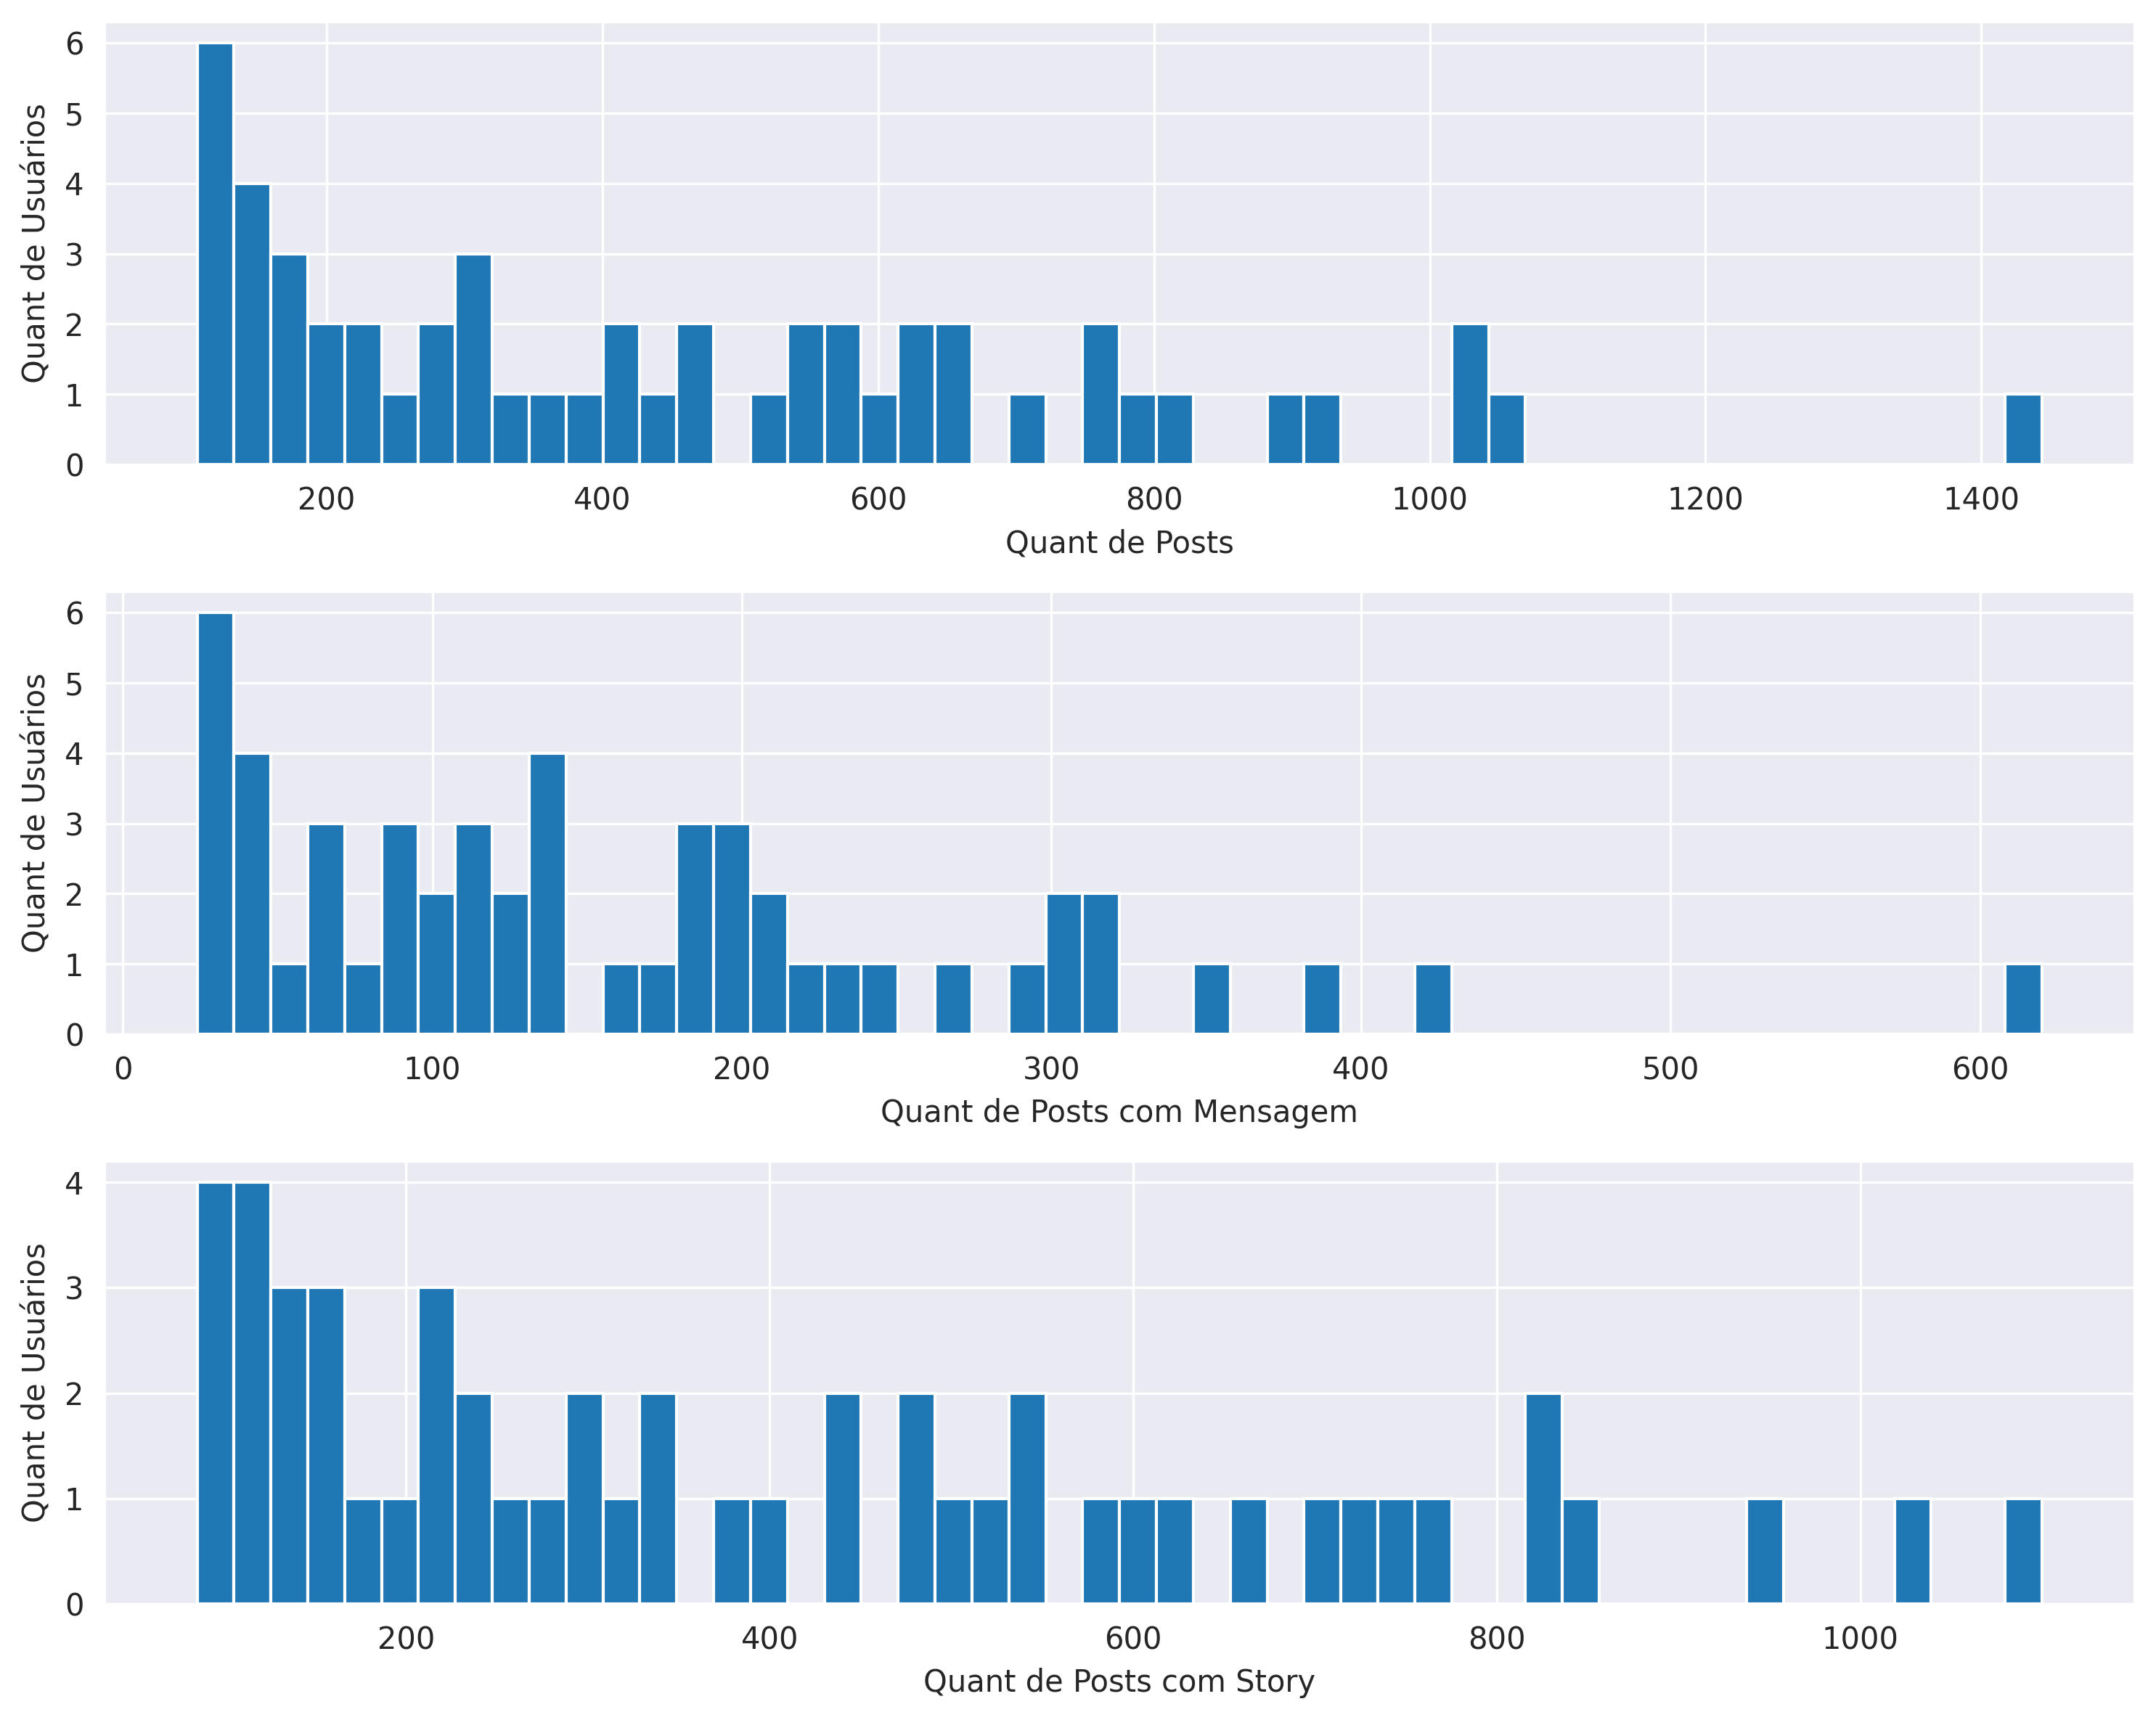

In [333]:
plotar_histogramas_posts(df_posts_interacoes)

In [334]:
def plotar_histogramas_interacoes(df):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), dpi=300)

    # Quantidade de atualização de Perfil
    quant_profile = df.groupby('id_usuario')['quantProfile'].sum().reset_index(name='quant_profile')
    axs[0, 0].hist(quant_profile['quant_profile'], bins=50)
    axs[0, 0].set_xlabel('Quant de Atualizações de Perfil')
    axs[0, 0].set_ylabel('Quant de Usuários')

    # Quantidade de atualização de Capa
    quant_cover = df.groupby('id_usuario')['quantCover'].sum().reset_index(name='quant_cover')
    axs[0, 1].hist(quant_cover['quant_cover'], bins=50)
    axs[0, 1].set_xlabel('Quant de Atualizações de Capa')
    axs[0, 1].set_ylabel('Quant de Usuários')

    # Quantidade de fotos com outras pessoas
    quant_photo_with_others = df.groupby('id_usuario')['quantAddPhotoWithOthers'].sum().reset_index(
        name='quant_photo_with_others')
    axs[1, 0].hist(quant_photo_with_others['quant_photo_with_others'], bins=50)
    axs[1, 0].set_xlabel('Quant de Fotos com Outras Pessoas')
    axs[1, 0].set_ylabel('Quant de Usuários')

    # Quantidade de está com outras pessoas
    quant_is_with_others = df.groupby('id_usuario')['quantIsWithOthers'].sum().reset_index(name='quant_is_with_others')
    axs[1, 1].hist(quant_is_with_others['quant_is_with_others'], bins=50)
    axs[1, 1].set_xlabel('Quant de Está com Outras Pessoas')
    axs[1, 1].set_ylabel('Quant de Usuários')

    # Quantidade de fotos adicionadas
    quant_add_photo = df.groupby('id_usuario')['quantAddPhoto'].sum().reset_index(name='quant_add_photo')
    axs[2, 0].hist(quant_add_photo['quant_add_photo'], bins=50)
    axs[2, 0].set_xlabel('Quant de Fotos Adicionadas')
    axs[2, 0].set_ylabel('Quant de Usuários')

    # Quantidade de fotos compartilhadas
    quant_shared_photo = df.groupby('id_usuario')['quantSharedPhoto'].sum().reset_index(name='quant_shared_photo')
    axs[2, 1].hist(quant_shared_photo['quant_shared_photo'], bins=50)
    axs[2, 1].set_xlabel('Quant de Fotos Compartilhadas')
    axs[2, 1].set_ylabel('Quant de Usuários')

    plt.tight_layout()
    plt.show()

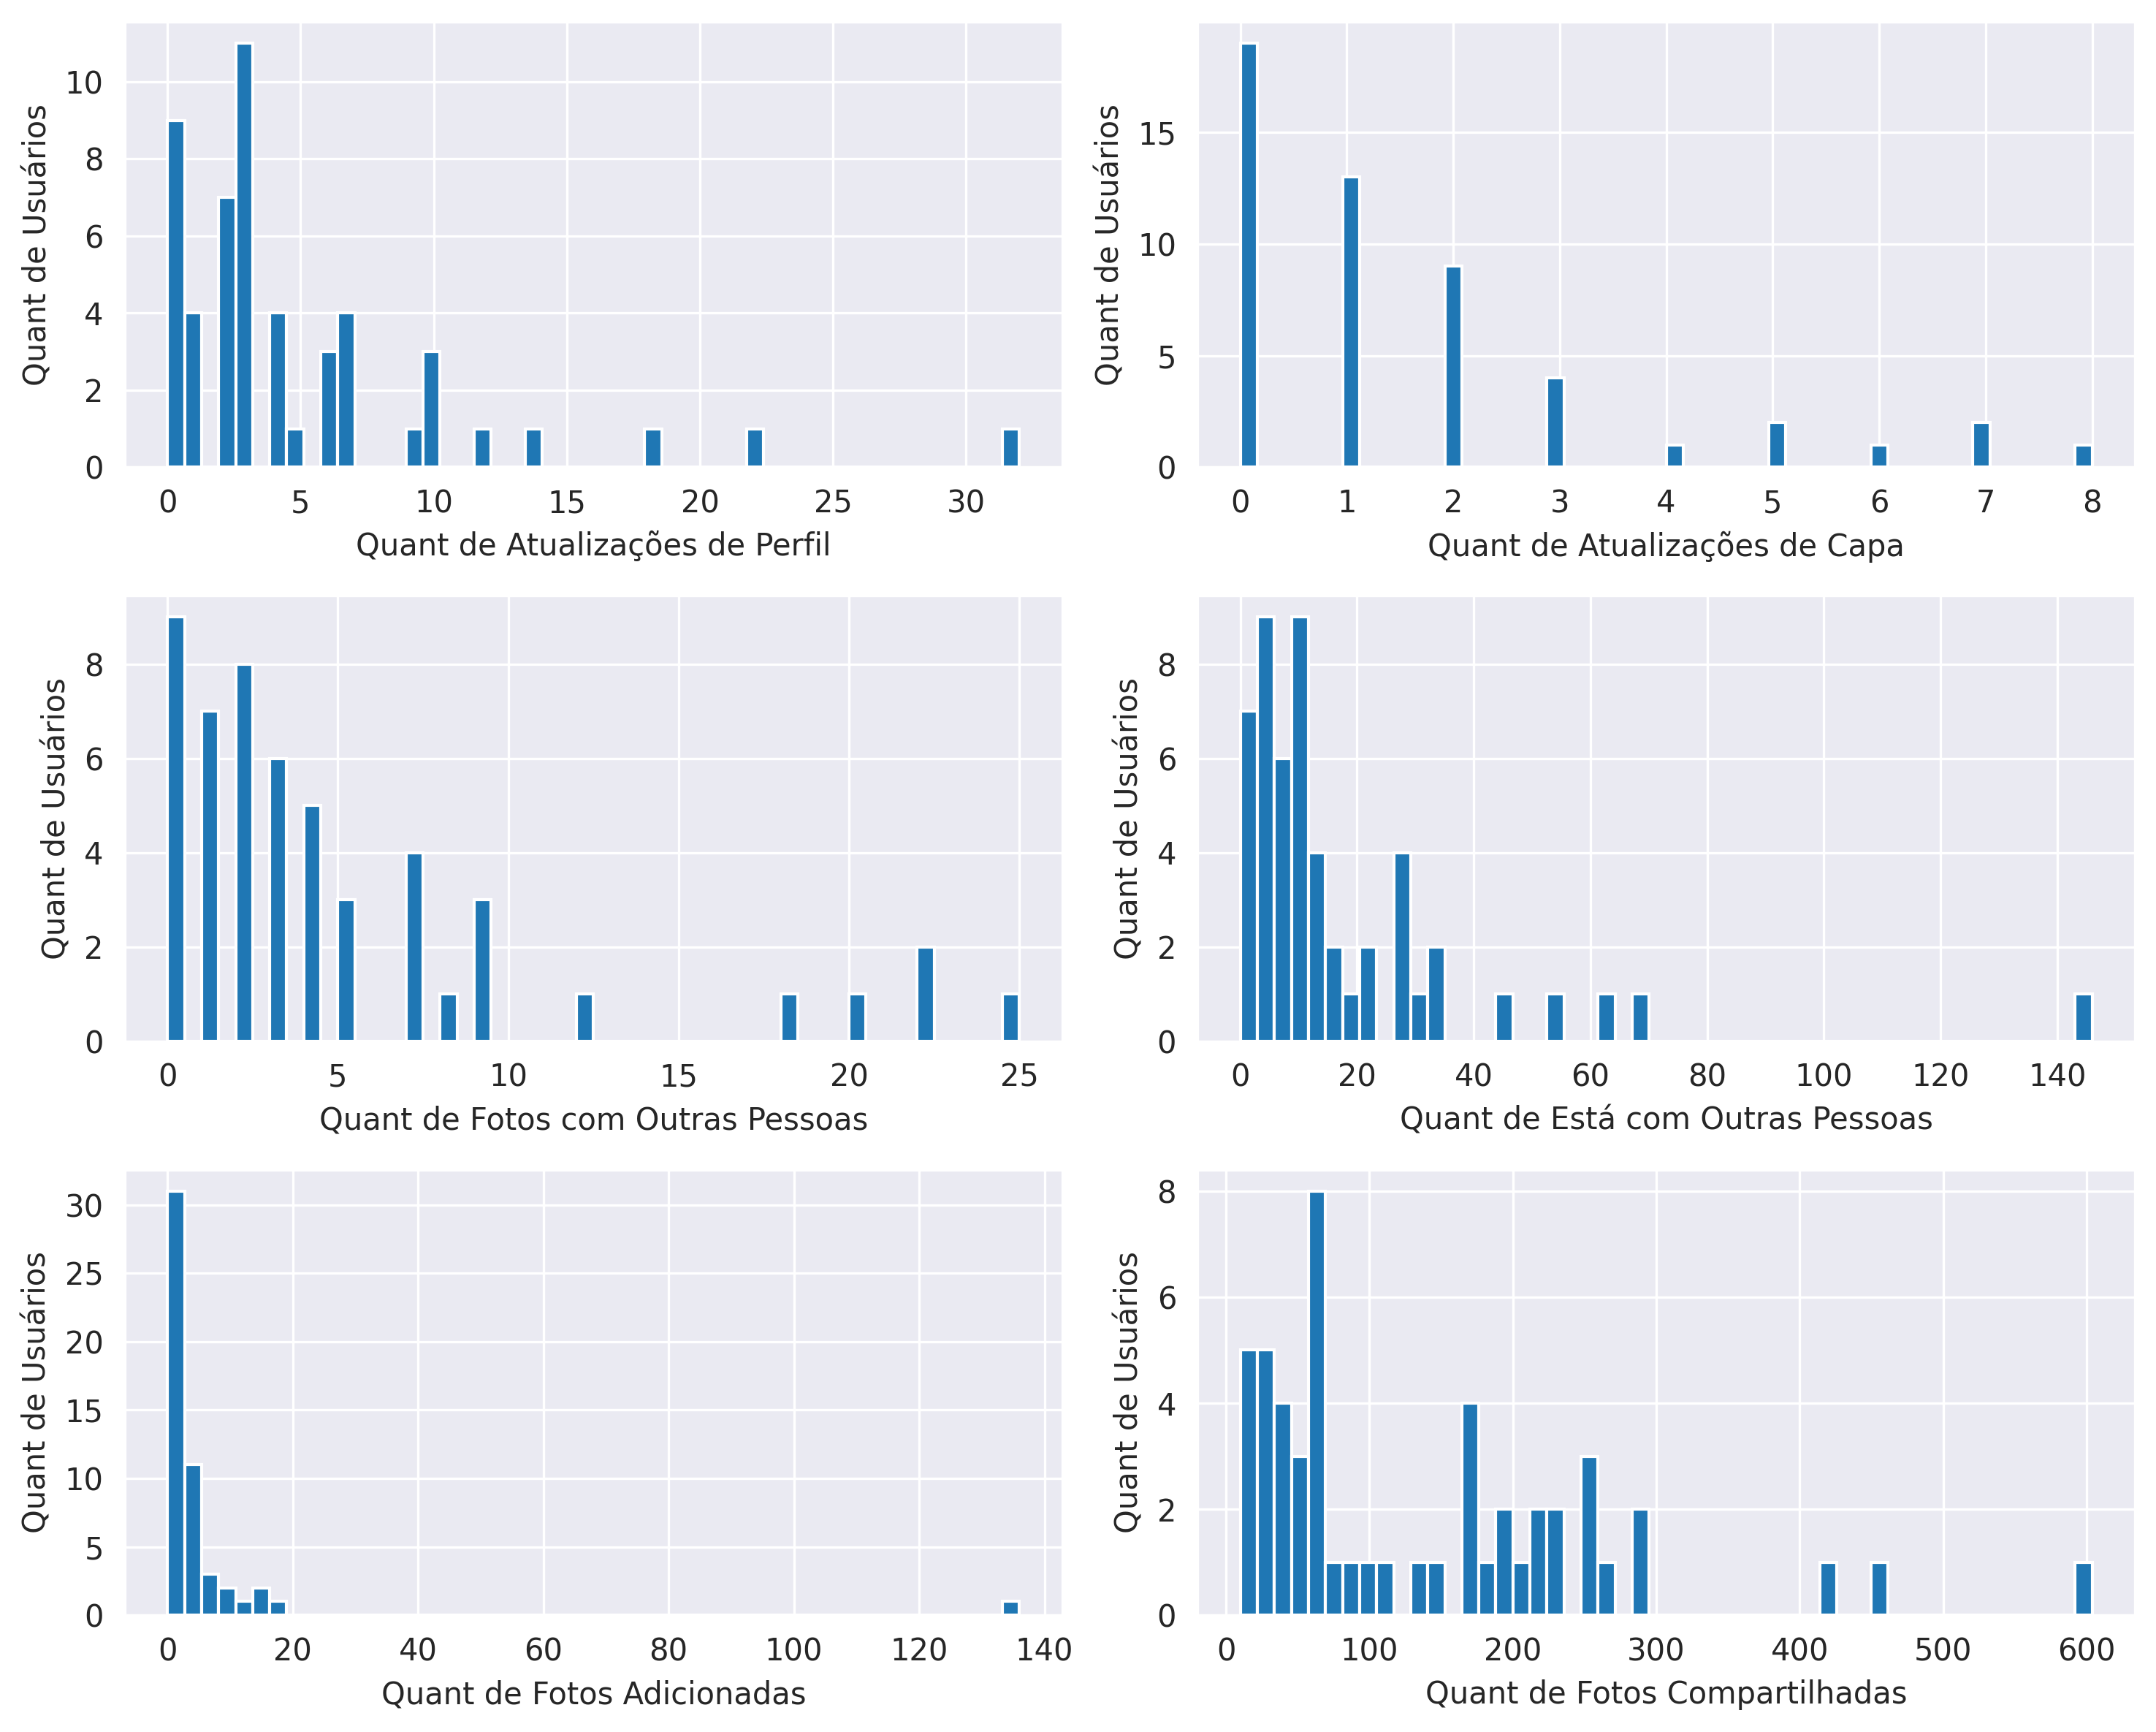

In [335]:
plotar_histogramas_interacoes(df_posts_interacoes)

In [336]:
def plotar_histogramas_interacoes_2(df):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), dpi=300)

    # Quantidade de vídeos compartilhados
    quant_shared_video = df.groupby('id_usuario')['quantSharedVideo'].sum().reset_index(name='quant_shared_video')
    axs[0, 0].hist(quant_shared_video['quant_shared_video'], bins=50)
    axs[0, 0].set_xlabel('Quant de Vídeos Compartilhados')
    axs[0, 0].set_ylabel('Quant de Usuários')

    # Quantidade de links compartilhados
    quant_shared_link = df.groupby('id_usuario')['quantSharedLink'].sum().reset_index(name='quant_shared_link')
    axs[0, 1].hist(quant_shared_link['quant_shared_link'], bins=50)
    axs[0, 1].set_xlabel('Quant de Links Compartilhados')
    axs[0, 1].set_ylabel('Quant de Usuários')

    # Quantidade de posts compartilhados
    quant_shared_post = df.groupby('id_usuario')['quantSharedPost'].sum().reset_index(name='quant_shared_post')
    axs[1, 0].hist(quant_shared_post['quant_shared_post'], bins=50)
    axs[1, 0].set_xlabel('Quant de Posts Compartilhados')
    axs[1, 0].set_ylabel('Quant de Usuários')

    # Quantidade de eventos compartilhados
    quant_shared_event = df.groupby('id_usuario')['quantSharedEvent'].sum().reset_index(name='quant_shared_event')
    axs[1, 1].hist(quant_shared_event['quant_shared_event'], bins=50)
    axs[1, 1].set_xlabel('Quant de Eventos Compartilhados')
    axs[1, 1].set_ylabel('Quant de Usuários')

    # Quantidade de memórias compartilhadas
    quant_shared_memory = df.groupby('id_usuario')['quantSharedMemory'].sum().reset_index(name='quant_shared_memory')
    axs[2, 0].hist(quant_shared_memory['quant_shared_memory'], bins=50)
    axs[2, 0].set_xlabel('Quant de Memórias Compartilhadas')
    axs[2, 0].set_ylabel('Quant de Usuários')

    # Quantidade de status
    quant_status = df.groupby('id_usuario')['quantStatus'].sum().reset_index(name='quant_status')
    axs[2, 1].hist(quant_status['quant_status'], bins=50)
    axs[2, 1].set_xlabel('Quant de Atualizações de Status')
    axs[2, 1].set_ylabel('Quant de Usuários')

    plt.tight_layout()
    plt.show()

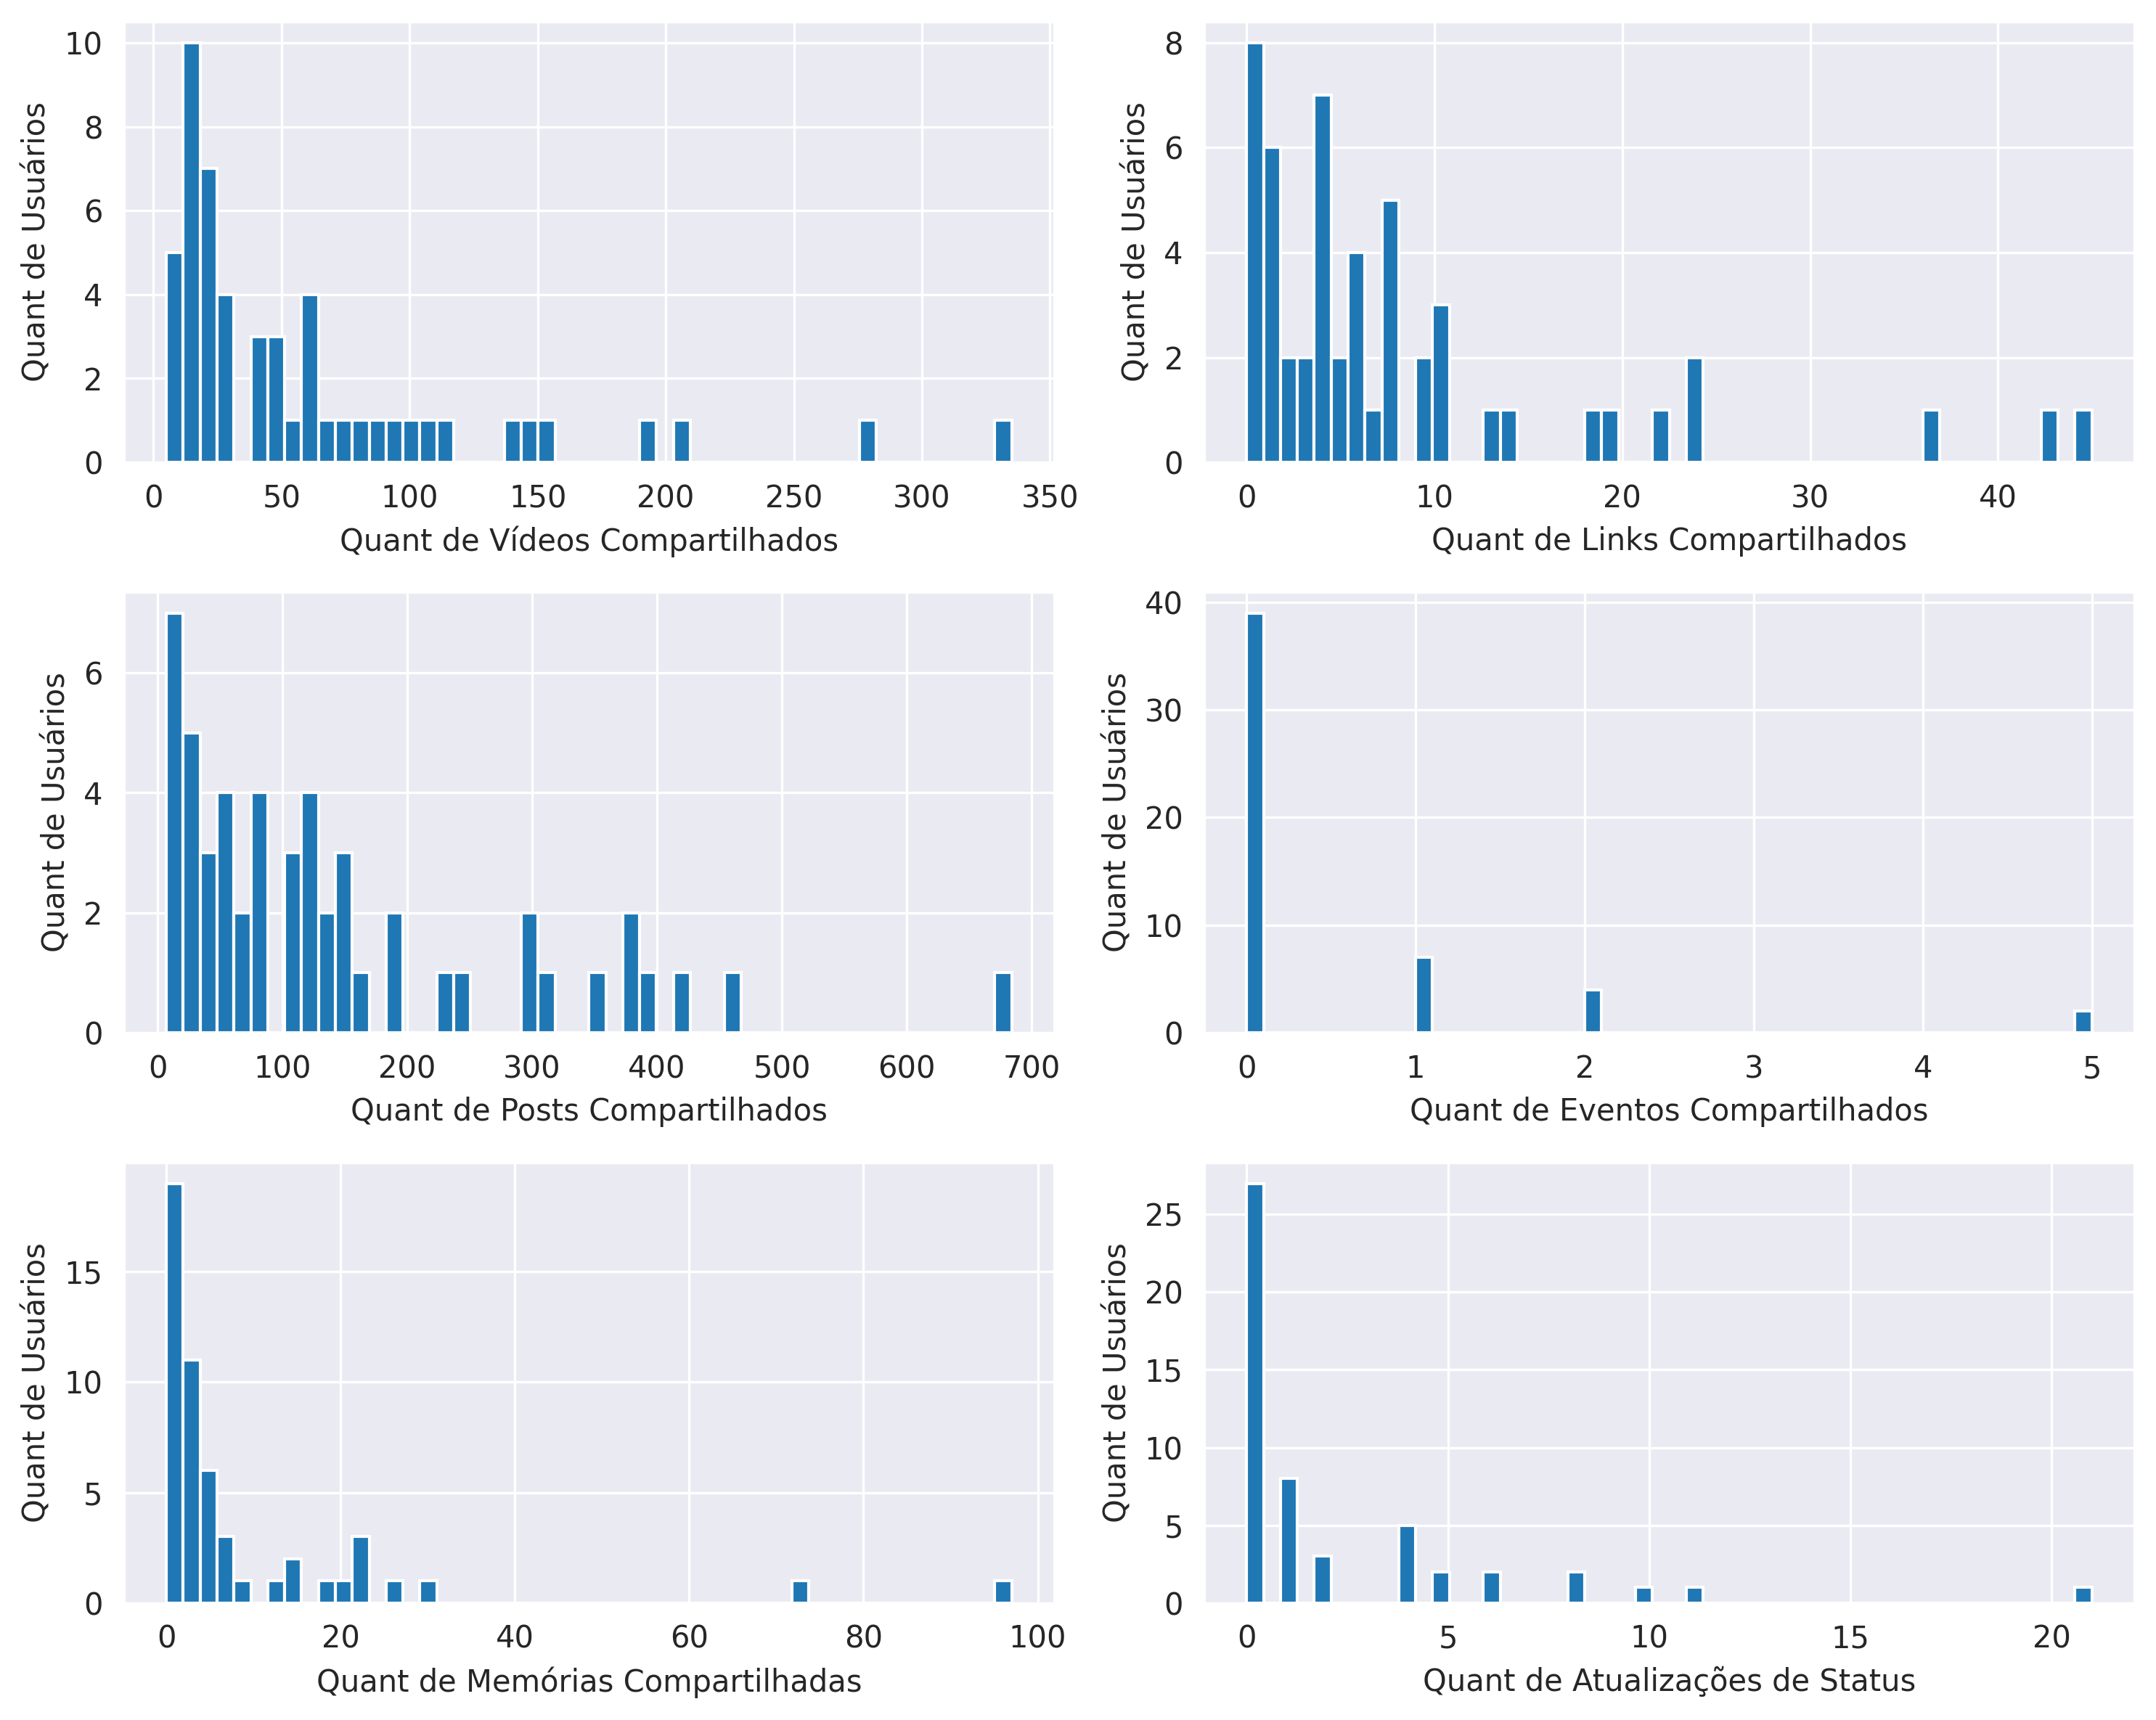

In [337]:
plotar_histogramas_interacoes_2(df_posts_interacoes)

In [338]:
df_agrupado_soma = df_posts_interacoes.groupby(['id_usuario']).agg(
    quantPosts=('quantPosts', 'sum'),
    somaProfile=('quantProfile', 'sum'),
    somaCover=('quantCover', 'sum'),
    somaAddPhotoWithOthers=('quantAddPhotoWithOthers', 'sum'),
    somaIsWithOthers=('quantIsWithOthers', 'sum'),
    somaAddPhoto=('quantAddPhoto', 'sum'),
    somaSharedPhoto=('quantSharedPhoto', 'sum'),
    somaSharedVideo=('quantSharedVideo', 'sum'),
    somaSharedLink=('quantSharedLink', 'sum'),
    somaSharedPost=('quantSharedPost', 'sum'),
    pessimismo=('pessimismo', 'first'),
    tristeza=('tristeza', 'first'),
    fracasso=('fracasso', 'first'),
    prazer=('prazer', 'first'),
    culpa=('culpa', 'first'),
    punicao=('punicao', 'first'),
    estima=('estima', 'first'),
    critica=('critica', 'first'),
    choro=('choro', 'first'),
    agitacao=('agitacao', 'first'),
    interesse=('interesse', 'first'),
    indecisao=('indecisao', 'first'),
    desvalorizacao=('desvalorizacao', 'first'),
    energia=('energia', 'first'),
    sono=('sono', 'first'),
    irritabilidade=('irritabilidade', 'first'),
    apetite=('apetite', 'first'),
    concentracao=('concentracao', 'first'),
    fadiga=('fadiga', 'first'),
    int_sexo=('int_sexo', 'first')
).reset_index()

In [339]:
df_likes_agrupado = df_likes.groupby('id_usuario').agg(somaLikes=('quantLikes', 'sum'))

# Juntar os dataframes
df_agrupado_soma = df_agrupado_soma.merge(df_likes_agrupado, on='id_usuario', how='left')

# Preencher valores NaN com 0
df_agrupado_soma.fillna(0, inplace=True)

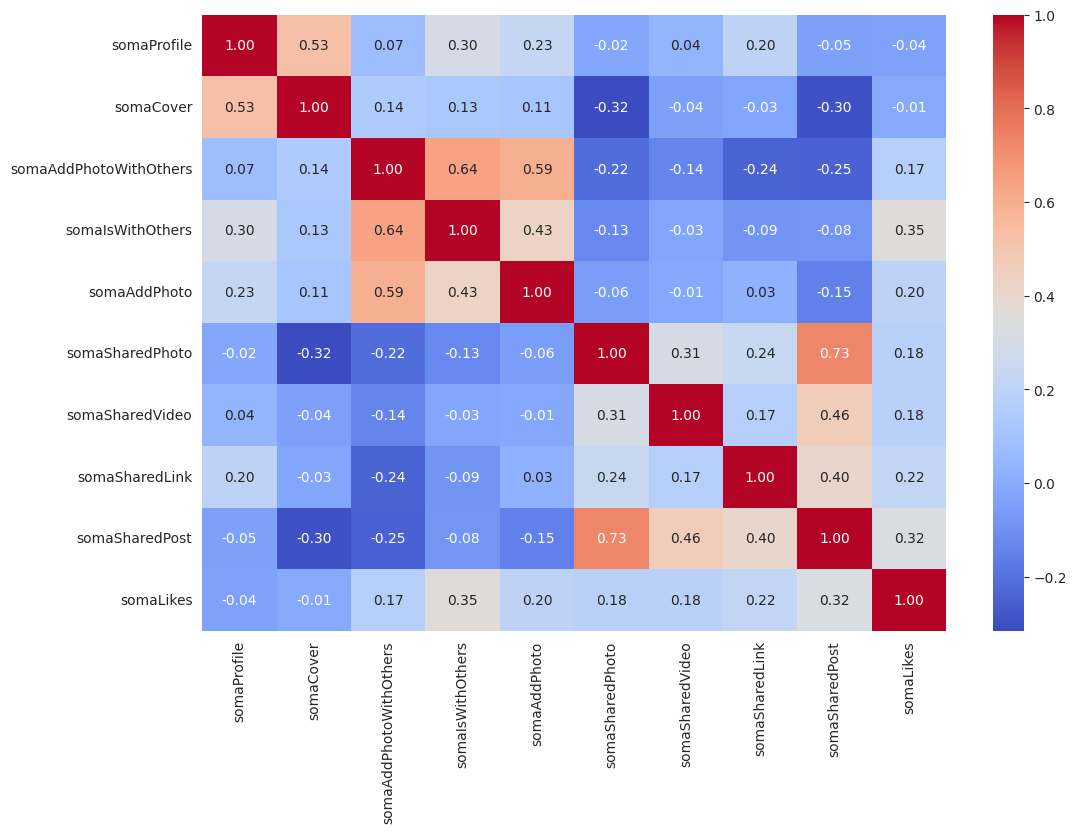

In [340]:
# Criar uma matriz de correlação
colunas_interacoes = df_agrupado_soma[[
    'somaProfile', 'somaCover', 'somaAddPhotoWithOthers', 'somaIsWithOthers', 'somaAddPhoto', 'somaSharedPhoto',
    'somaSharedVideo', 'somaSharedLink', 'somaSharedPost', 'somaLikes'
]]

matriz_correlacao = colunas_interacoes.corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [341]:
from scipy.stats import spearmanr

# Testar para todas as combinações de variáveis
for i in range(len(colunas_interacoes.columns)):
    for j in range(i + 1, len(colunas_interacoes.columns)):
        x = colunas_interacoes.iloc[:, i]
        y = colunas_interacoes.iloc[:, j]

        spearman_corr, p_value = spearmanr(x, y)
        print(
            f'Correlação de Spearman entre {colunas_interacoes.columns[i]} e {colunas_interacoes.columns[j]}: {spearman_corr}')
        print(f'P-valor de Spearman: {p_value}')

Correlação de Spearman entre somaProfile e somaCover: 0.5260034560158057
P-valor de Spearman: 6.20712568036228e-05
Correlação de Spearman entre somaProfile e somaAddPhotoWithOthers: 0.0704150603217787
P-valor de Spearman: 0.6198638580786464
Correlação de Spearman entre somaProfile e somaIsWithOthers: 0.2990647682702014
P-valor de Spearman: 0.03126205559225619
Correlação de Spearman entre somaProfile e somaAddPhoto: 0.22939052139271374
P-valor de Spearman: 0.1018725195315678
Correlação de Spearman entre somaProfile e somaSharedPhoto: -0.022235624835416867
P-valor de Spearman: 0.8756666216204863
Correlação de Spearman entre somaProfile e somaSharedVideo: 0.03670484541383309
P-valor de Spearman: 0.7961481801889605
Correlação de Spearman entre somaProfile e somaSharedLink: 0.2016082069897623
P-valor de Spearman: 0.15178904756204484
Correlação de Spearman entre somaProfile e somaSharedPost: -0.048221308852617065
P-valor de Spearman: 0.7342531002734399
Correlação de Spearman entre somaProfil

In [342]:
# df_agrupado_soma['mediaInteracoesComOutros'] = df_agrupado_soma[[
#     'somaAddPhotoWithOthers', 'somaIsWithOthers'
# ]].mean(axis=1).round(2)
# 
# df_agrupado_soma['mediaSharedPhotoPostVideo'] = df_agrupado_soma[[
#     'somaSharedPhoto', 'somaSharedPost', 'somaSharedVideo', 'somaSharedLink'
# ]].mean(axis=1).round(2)
# 
# df_agrupado_soma['mediaAtualizacaoPerfil'] = df_agrupado_soma[[
#     'somaProfile', 'somaCover'
# ]].mean(axis=1).round(2)

In [356]:
from sklearn.preprocessing import StandardScaler

variaveis = df_agrupado_soma[[
    'quantPosts'
]]

# Normalizar as variáveis
scaler = StandardScaler()
variaveis_normalizadas = scaler.fit_transform(variaveis)

Variância explicada por cada componente: [1.]


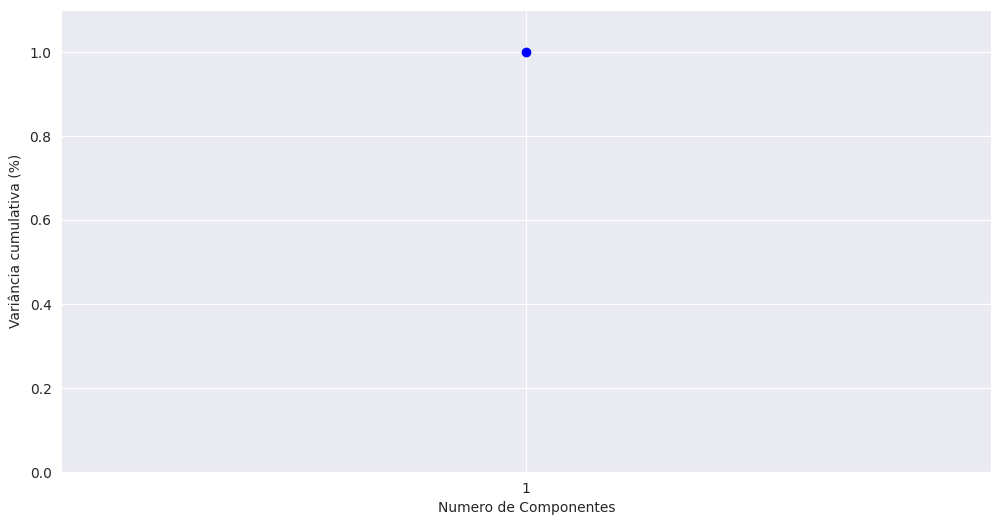

In [357]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=0.75)
pca_resultado = pca.fit_transform(variaveis_normalizadas)

print("Variância explicada por cada componente:", pca.explained_variance_ratio_)

plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()

xi = np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1)

y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Numero de Componentes')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, step=1))
plt.ylabel('Variância cumulativa (%)')

plt.grid(True)

plt.show()

In [358]:
k_values = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_resultado)
    inertias.append(kmeans.inertia_)

    # Obter os rótulos dos clusters
    labels = kmeans.labels_

    # Calcular o Coeficiente de Silhueta
    silhouette_avg = silhouette_score(pca_resultado, labels)
    silhouette_scores.append(silhouette_avg)

    # Calcular o Índice de Davies-Bouldin
    db_index = davies_bouldin_score(pca_resultado, labels)
    davies_bouldin_scores.append(db_index)

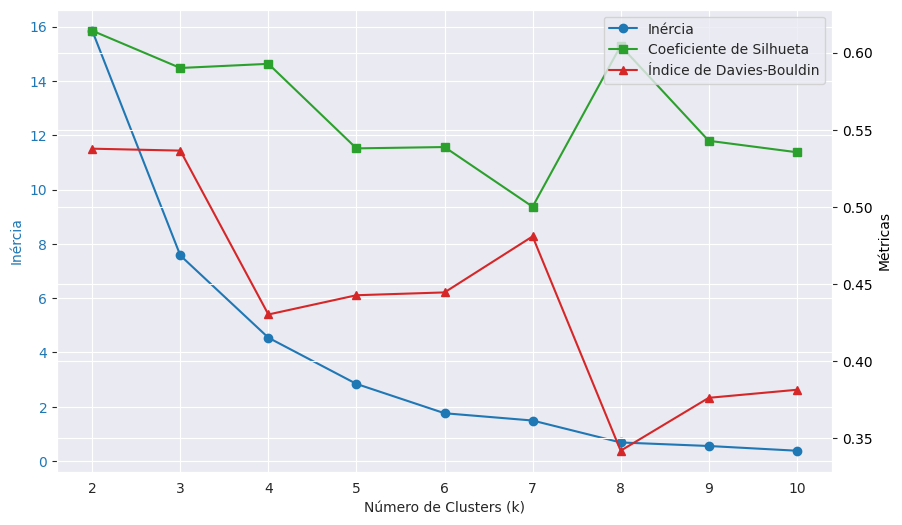

In [359]:
# Plotar as métricas em um único gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico da Inércia
color_inertia = 'tab:blue'
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia', color=color_inertia)
ax1.plot(k_values, inertias, marker='o', color=color_inertia, label='Inércia')
ax1.tick_params(axis='y', labelcolor=color_inertia)
ax1.set_xticks(k_values)

ax2 = ax1.twinx()

color_silhouette = 'tab:green'
color_db = 'tab:red'
ax2.set_ylabel('Métricas', color='black')
ax2.plot(k_values, silhouette_scores, marker='s', color=color_silhouette, label='Coeficiente de Silhueta')
ax2.plot(k_values, davies_bouldin_scores, marker='^', color=color_db, label='Índice de Davies-Bouldin')
ax2.tick_params(axis='y', labelcolor='black')

# Combinar as legendas
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax2.legend(lines, labels, loc='upper right')

# Título do Gráfico
# plt.title('Avaliação do K-Means com Inércia, Coeficiente de Silhueta e Índice de Davies-Bouldin')

plt.show()

In [360]:
# Printar o silhouette score junto com o número de clusters
for k, score in zip(k_values, silhouette_scores):
    print(f'Número de Clusters: {k} - Coeficiente de Silhueta: {score}')

print('\n')

# Printar o índice de Davies-Bouldin junto com o número de clusters
for k, score in zip(k_values, davies_bouldin_scores):
    print(f'Número de Clusters: {k} - Índice de Davies-Bouldin: {score}')

Número de Clusters: 2 - Coeficiente de Silhueta: 0.6142473545214233
Número de Clusters: 3 - Coeficiente de Silhueta: 0.5900785736083366
Número de Clusters: 4 - Coeficiente de Silhueta: 0.5927660469428735
Número de Clusters: 5 - Coeficiente de Silhueta: 0.537924028575698
Número de Clusters: 6 - Coeficiente de Silhueta: 0.5387888079174322
Número de Clusters: 7 - Coeficiente de Silhueta: 0.5000814375557805
Número de Clusters: 8 - Coeficiente de Silhueta: 0.6044439062335325
Número de Clusters: 9 - Coeficiente de Silhueta: 0.5428504945456143
Número de Clusters: 10 - Coeficiente de Silhueta: 0.5354198242253307


Número de Clusters: 2 - Índice de Davies-Bouldin: 0.537724737905396
Número de Clusters: 3 - Índice de Davies-Bouldin: 0.536471482850689
Número de Clusters: 4 - Índice de Davies-Bouldin: 0.43016767609905326
Número de Clusters: 5 - Índice de Davies-Bouldin: 0.4426570970893987
Número de Clusters: 6 - Índice de Davies-Bouldin: 0.44448569140530764
Número de Clusters: 7 - Índice de Davies-

In [377]:
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(variaveis_normalizadas)

df_agrupado_soma['cluster'] = kmeans.labels_

print(df_agrupado_soma[['id_usuario', 'cluster']].head())

          id_usuario  cluster
0  10214421550670970        0
1   1022864967872047        1
2   1033110380164779        2
3   1170510339747390        1
4   1211223432346372        1


In [378]:
df_agrupado_soma.to_csv('df_agrupado_soma.csv', index=False)
df_agrupado_soma['cluster'].value_counts()

cluster
1    24
2    18
0    10
Name: count, dtype: int64

In [379]:
def teste_mk(df_cluster, periodo, tipo_serie='posts'):
    resultados_mk = []

    for usuario in df_cluster['id_usuario'].unique():
        df_usuario = df_cluster[df_cluster['id_usuario'] == usuario]

        eventos_por_dia = df_usuario.groupby('data').size()

        if len(eventos_por_dia) >= 2 * periodo:
            try:
                resultado = seasonal_decompose(eventos_por_dia, model='additive', period=periodo)
                tendencia = resultado.trend.dropna()

                if len(tendencia) > 0:
                    result = original_test(tendencia)

                    if hasattr(result, 'trend'):
                        resultados_mk.append({
                            'id_usuario': usuario,
                            'trend': result.trend,
                            'h': result.h,
                            'p-valor': result.p,
                            'z': result.z,
                            'Tau': result.Tau,
                            's': result.s,
                            'var_s': result.var_s,
                            'slope': result.slope,
                            'intercept': result.intercept
                        })
                    else:
                        print(f"Usuário {usuario} - Resultado do teste de Mann-Kendall sem 'trend'.")
                else:
                    print(f"Usuário {usuario} - Não foi possível decompor dados suficientes para tendência.")
            except ValueError as e:
                print(f"Erro ao decompor a série para o usuário {usuario}: {e}")
        else:
            print(
                f"Usuário {usuario} não tem observações suficientes para decomposição. Necessário: {2 * periodo}, disponível: {len(eventos_por_dia)}")

    # Criando o DataFrame apenas se houver resultados suficientes
    if resultados_mk:
        df_resultados_mk = pd.DataFrame(resultados_mk)

        if 'trend' in df_resultados_mk.columns:
            contagem_tendencias = df_resultados_mk['trend'].value_counts()
            print(contagem_tendencias)

            total_usuarios = df_resultados_mk.shape[0]
            percentuais = (contagem_tendencias / total_usuarios) * 100
            print(percentuais)

            # Gráfico de barras das tendências
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df_resultados_mk, x='trend', order=['increasing', 'decreasing', 'no trend'])
            plt.title(f'Distribuição de Tendências entre Usuários ({tipo_serie.capitalize()})')
            plt.xlabel('Tipo de Tendência')
            plt.ylabel('Número de Usuários')
            plt.show()

            # Gráfico de distribuição dos slopes
            plt.figure(figsize=(10, 6))
            sns.histplot(df_resultados_mk['slope'], bins=20, kde=True)
            plt.title(f'Distribuição dos Slopes entre Usuários ({tipo_serie.capitalize()})')
            plt.xlabel('Slope')
            plt.ylabel('Frequência')
            plt.show()

        else:
            print("Nenhuma tendência foi detectada nos dados.")

        return df_resultados_mk
    else:
        print("Nenhum dado disponível para análise.")
        return pd.DataFrame()

In [380]:
# buscar no dataframe df_posts_interacoes os usuários do cluster 0, 1 e 2
df_cluster0_soma = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_agrupado_soma[df_agrupado_soma['cluster'] == 0]['id_usuario'])]
df_cluster1_soma = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_agrupado_soma[df_agrupado_soma['cluster'] == 1]['id_usuario'])]
df_cluster2_soma = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_agrupado_soma[df_agrupado_soma['cluster'] == 2]['id_usuario'])]

Usuário 872507229580251 não tem observações suficientes para decomposição. Necessário: 60, disponível: 48
trend
increasing    5
decreasing    4
Name: count, dtype: int64
trend
increasing    55.555556
decreasing    44.444444
Name: count, dtype: float64


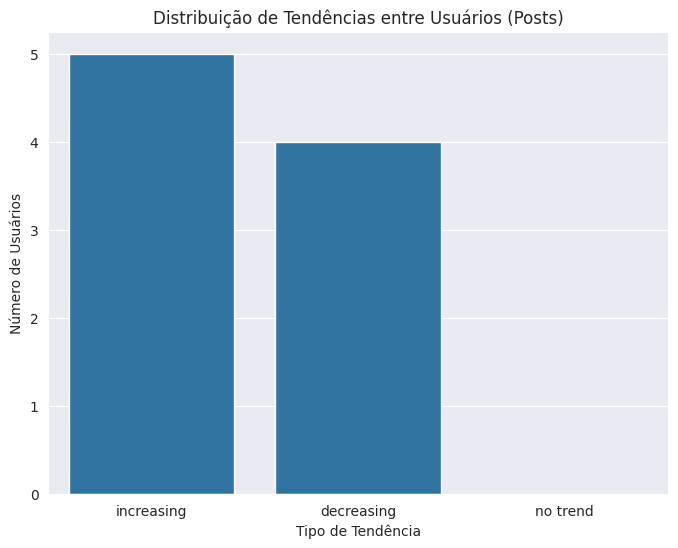

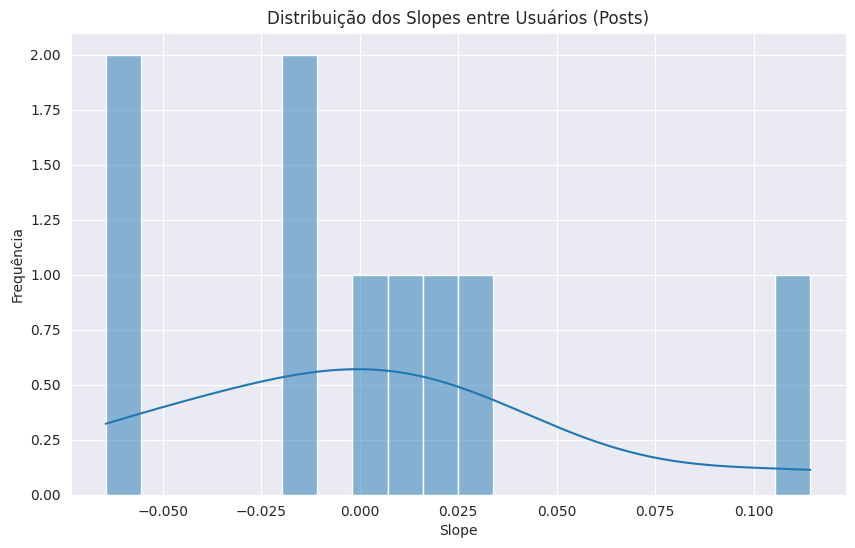

Usuário 1257481127685383 não tem observações suficientes para decomposição. Necessário: 60, disponível: 56
Usuário 299741130514772 não tem observações suficientes para decomposição. Necessário: 60, disponível: 50
trend
decreasing    11
increasing     7
no trend       4
Name: count, dtype: int64
trend
decreasing    50.000000
increasing    31.818182
no trend      18.181818
Name: count, dtype: float64


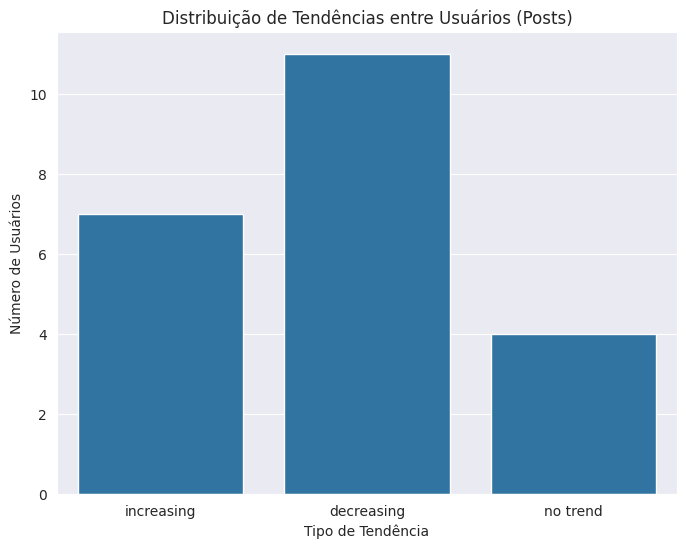

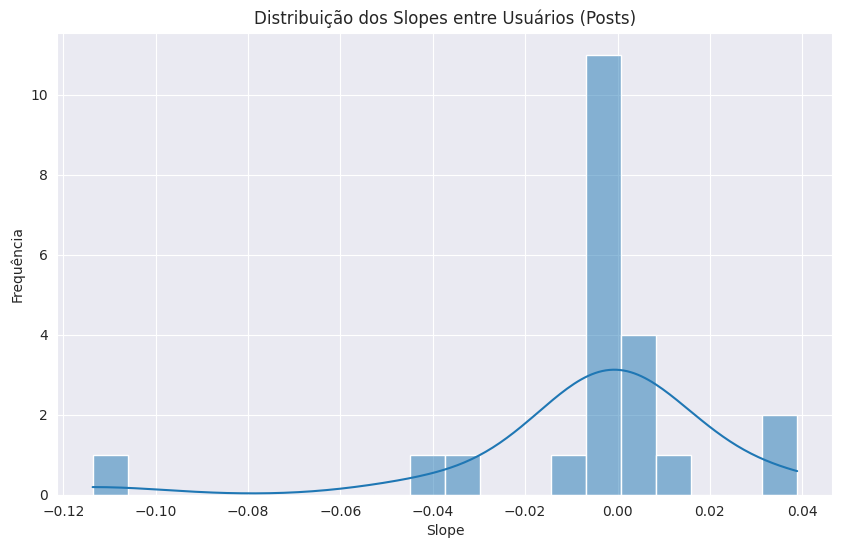

trend
decreasing    11
no trend       4
increasing     3
Name: count, dtype: int64
trend
decreasing    61.111111
no trend      22.222222
increasing    16.666667
Name: count, dtype: float64


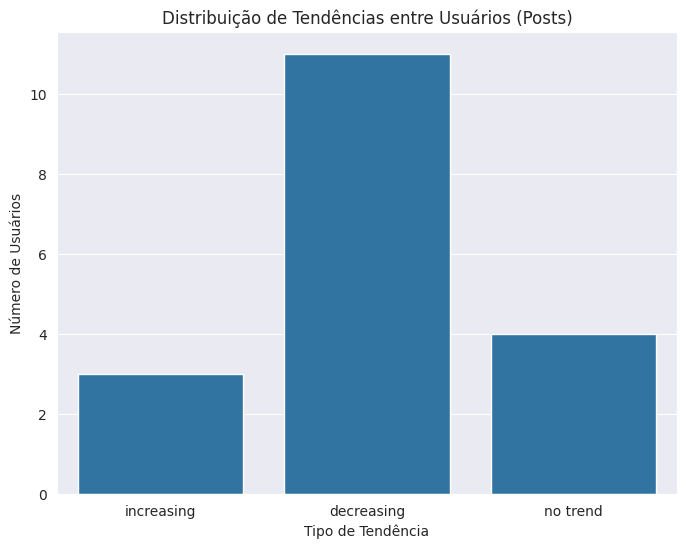

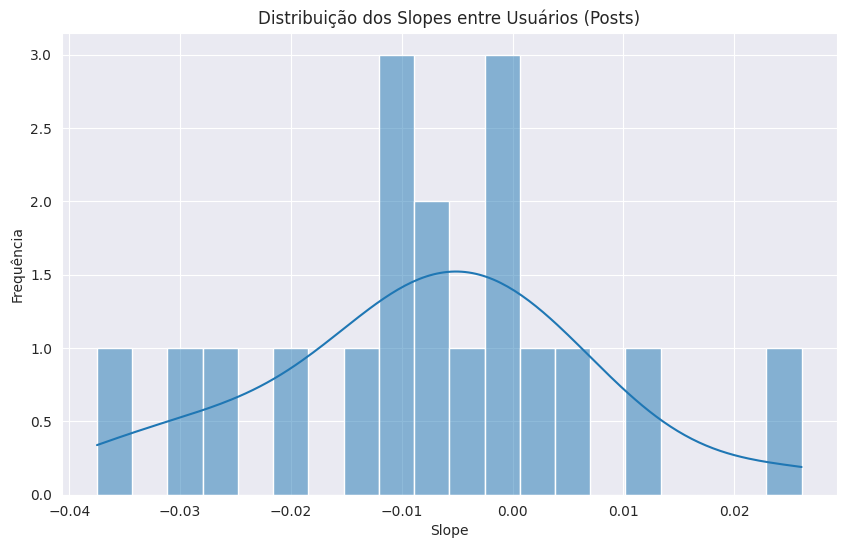

In [381]:
resultados_mk_cluster0 = teste_mk(df_cluster0_soma, 30)
resultados_mk_cluster1 = teste_mk(df_cluster1_soma, 30)
resultados_mk_cluster2 = teste_mk(df_cluster2_soma, 30)

In [382]:
# Filtrar o DataFrame para manter apenas os usuários com cluster igual a 1
df_cluster_0 = df_agrupado_soma[df_agrupado_soma['cluster'] == 0]
df_cluster_0.describe()

,quantPosts,somaProfile,somaCover,somaAddPhotoWithOthers,somaIsWithOthers,somaAddPhoto,somaSharedPhoto,somaSharedVideo,somaSharedLink,somaSharedPost,...,desvalorizacao,energia,sono,irritabilidade,apetite,concentracao,fadiga,int_sexo,somaLikes,cluster
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,948.400000,3.600000,0.800000,4.800000,26.500000,15.300000,271.500000,118.700000,14.200000,364.200000,...,2.600000,2.300000,2.300000,2.100000,2.500000,2.100000,2.700000,1.900000,306.400000,0.0
std,208.747162,4.247875,0.918937,7.192589,44.214754,42.518101,174.132293,91.968654,15.476147,142.798848,...,0.699206,0.483046,0.823273,0.875595,0.849837,0.316228,0.483046,1.286684,263.815676,0.0
min,754.000000,0.000000,0.000000,0.000000,1.000000,0.000000,59.000000,38.000000,1.000000,157.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,16.000000,0.0
25%,791.750000,0.500000,0.000000,0.250000,4.250000,0.000000,175.250000,53.500000,3.250000,298.750000,...,2.250000,2.000000,2.000000,1.250000,2.250000,2.000000,2.250000,1.000000,97.000000,0.0
50%,904.000000,3.000000,0.500000,1.000000,8.500000,1.000000,230.500000,97.000000,8.500000,348.500000,...,3.000000,2.000000,2.500000,2.000000,3.000000,2.000000,3.000000,2.500000,203.500000,0.0
75%,1031.000000,3.750000,1.750000,6.250000,24.250000,2.750000,388.000000,135.250000,20.500000,411.250000,...,3.000000,2.750000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,549.750000,0.0
max,1444.000000,14.000000,2.000000,22.000000,146.000000,136.000000,604.000000,335.000000,45.000000,684.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,740.000000,0.0


In [383]:
df_cluster_1 = df_agrupado_soma[df_agrupado_soma['cluster'] == 1]
df_cluster_1.describe()

,quantPosts,somaProfile,somaCover,somaAddPhotoWithOthers,somaIsWithOthers,somaAddPhoto,somaSharedPhoto,somaSharedVideo,somaSharedLink,somaSharedPost,...,desvalorizacao,energia,sono,irritabilidade,apetite,concentracao,fadiga,int_sexo,somaLikes,cluster
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.0
mean,198.000000,3.791667,1.958333,6.083333,14.083333,2.916667,49.916667,29.333333,4.583333,48.166667,...,2.333333,2.083333,2.041667,2.333333,2.458333,2.000000,2.625000,1.00000,117.541667,1.0
std,76.343047,3.945048,1.731528,6.412736,14.424968,3.682115,42.720443,19.990577,5.290818,38.967843,...,0.916831,0.775532,0.858673,0.816497,0.883627,0.884652,0.646899,1.14208,123.822095,0.0
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,5.000000,0.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,5.000000,1.0
25%,131.000000,1.750000,1.000000,2.750000,3.000000,0.000000,22.000000,15.750000,0.750000,15.750000,...,2.000000,2.000000,1.750000,2.000000,2.000000,2.000000,2.000000,0.00000,54.000000,1.0
50%,178.500000,3.000000,1.500000,4.000000,11.000000,2.000000,41.500000,23.000000,3.500000,35.500000,...,3.000000,2.000000,2.000000,2.500000,3.000000,2.000000,3.000000,1.00000,68.500000,1.0
75%,263.750000,4.500000,3.000000,7.250000,21.500000,4.000000,61.500000,32.750000,7.250000,65.500000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.00000,122.750000,1.0
max,339.000000,18.000000,6.000000,25.000000,62.000000,16.000000,221.000000,77.000000,22.000000,133.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,570.000000,1.0


In [384]:
df_cluster_2 = df_agrupado_soma[df_agrupado_soma['cluster'] == 2]
df_cluster_2.describe()

,quantPosts,somaProfile,somaCover,somaAddPhotoWithOthers,somaIsWithOthers,somaAddPhoto,somaSharedPhoto,somaSharedVideo,somaSharedLink,somaSharedPost,...,desvalorizacao,energia,sono,irritabilidade,apetite,concentracao,fadiga,int_sexo,somaLikes,cluster
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,535.277778,7.111111,1.666667,3.555556,17.166667,4.000000,178.666667,72.722222,9.944444,151.222222,...,2.333333,2.388889,2.111111,2.166667,2.444444,2.055556,2.388889,1.388889,143.722222,2.0
std,102.501538,8.302295,2.700762,5.170302,18.513111,5.357787,73.033433,75.757202,10.641054,92.785366,...,0.766965,0.607685,1.022620,0.923548,0.783823,0.872604,0.697802,1.092159,116.942321,0.0
min,373.000000,0.000000,0.000000,0.000000,1.000000,0.000000,40.000000,7.000000,0.000000,55.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,24.000000,2.0
25%,452.750000,2.000000,0.000000,1.000000,7.250000,1.000000,137.500000,17.500000,4.000000,83.500000,...,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,62.000000,2.0
50%,549.500000,4.500000,0.500000,2.000000,10.500000,2.000000,186.500000,44.000000,6.000000,128.000000,...,2.500000,2.000000,2.500000,2.000000,3.000000,2.000000,2.500000,1.000000,104.000000,2.0
75%,609.500000,9.750000,1.750000,3.750000,18.000000,3.000000,233.500000,107.750000,12.250000,177.250000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,175.750000,2.0
max,720.000000,32.000000,8.000000,22.000000,69.000000,18.000000,288.000000,277.000000,43.000000,381.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,440.000000,2.0
